# Reference model

## 1. Setting environment up

In [21]:
from xtalphases.data.preprocess import *
import warnings
import sys
import scipy
import numpy
import matplotlib
import pandas
import sklearn
import yellowbrick
import pandas
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from yellowbrick.features import Rank2D
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
warnings.filterwarnings('ignore')

def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

## 2. Loading Dataset
- data/*_RCSB.pdb
- data/*_REDO_phases.cif  

merge their information
### 2.1 Raw data

In [2]:
cif_columns = ["index_h", "index_k", "index_l", "FOBS", "SIGFOBS", "FMODEL", "PHIMODEL", "FOM", "RESOL", "pdbx_r_free_flag"]

with open('list.txt') as f:
    file = f.read()
    id_list = file.split('\n')

In [3]:
# number of structures to use
n = 10
id_list = id_list[:n]

In [4]:
raw_dataset = pd.DataFrame()
raw_dataset_list = []

for index, x in enumerate(id_list):
    if (index+1)%20 == 0:
        print('Applying memory reduction to dataset')
        raw_dataset_list.append(reduce_mem_usage(raw_dataset))
        raw_dataset = pd.DataFrame()

    print(index, 'loading', x)
    pdb_file = f"data/{x}_RCSB.pdb"
    cif_file = f"data/{x}_REDO_phases.cif"
    pdb = PDBParser(pdb_file)
    pdb.parse()
    cif = CIFParser(cif_file, cif_columns=cif_columns)
    cif.parse()
    
    partial_dataset = cifpdb_df(cif.header_refln_df(), pdb.header_to_series())
    raw_dataset = raw_dataset.append(partial_dataset, ignore_index=True)

print('Applying memory reduction to dataset')
raw_dataset_list.append(reduce_mem_usage(raw_dataset))
raw_dataset = pd.DataFrame()
print('\n', len(id_list), ' structures were loaded!')

0 loading 3ato
1 loading 5v4g
2 loading 4h8y
3 loading 2ybj
4 loading 1h87
5 loading 4etd
6 loading 4lt0
7 loading 4tws
8 loading 3zvq
9 loading 3wu9
Applying memory reduction to dataset
Memory usage of dataframe is 41.40 MB
Memory usage after optimization is: 13.21 MB
Decreased by 68.1%

 10  structures were loaded!


### 2.2 Centric reflections
We can relate space group to point group according to [(RUPP. B, 2001)]() so that for each point groups there is a relation of centrossymetric reflections [(GIACOVAZZO, 1992)]()

In [5]:
while raw_dataset_list:
    print('appending dataset')
    raw_dataset = raw_dataset.append(raw_dataset_list.pop(), ignore_index=True)
    

appending dataset


In [6]:
with open('docs/pointgroup[ccp4].txt') as f:
    text = f.read()

number_to_point = {}
for each in text.split('\n')[1:-3]:
    line = each.split("'")
    number_to_point[int(line[0].strip())]= line[7]
    
# raw_dataset_ = raw_dataset.copy()
raw_dataset_ = raw_dataset
raw_dataset_.IT_number = raw_dataset_.IT_number.map(lambda x: number_to_point[x])
raw_dataset_ = raw_dataset_.rename(columns={"IT_number":"point_group"})

In [7]:
criterion2 = raw_dataset_[raw_dataset_.point_group == '2']
criterion222 = raw_dataset_[raw_dataset_.point_group == '222']
criterion4 = raw_dataset_[raw_dataset_.point_group == '4']
criterion422 = raw_dataset_[raw_dataset_.point_group == '422']
criterion32 = raw_dataset_[raw_dataset_.point_group == '32']
criterion6 = raw_dataset_[raw_dataset_.point_group == '6']
criterion62 = raw_dataset_[raw_dataset_.point_group == '62']
criterion23 = raw_dataset_[raw_dataset_.point_group == '23']
criterion432 = raw_dataset_[raw_dataset_.point_group == '432']

criterion2 = criterion2[criterion2.index_k == 0]
criterion222 = criterion222[(criterion222.index_h == 0) | (criterion222.index_k == 0) | (criterion222.index_l == 0)]
criterion4 = criterion4[criterion4.index_l == 0]
criterion422 = criterion422[(criterion422.index_l == 0) | (criterion422.index_k == 0) | ((criterion422.index_h == criterion422.index_k))]
criterion32 = criterion32[criterion32.index_k == 0] # third index is redundant
criterion6 = criterion6[criterion6.index_l == 0]
criterion62 = criterion62[(criterion62.index_l == 0) | (criterion62.index_k == 0) | (criterion62.index_h == criterion62.index_k)]
criterion23 = criterion23[criterion23.index_l == 0]
criterion432 = criterion432[(criterion432.index_l == 0) | (criterion432.index_h == criterion432.index_k)]

dataset_parts = [criterion2, criterion222, criterion4, criterion422,
                 criterion32, criterion6, criterion62, criterion23,
                criterion432]

In [8]:
preprocessed_dataset = pd.DataFrame()
while dataset_parts:
    preprocessed_dataset = preprocessed_dataset.append(dataset_parts.pop(), ignore_index=True)

Cleaning unused variables to free memory

In [9]:
del criterion2
del criterion222
del criterion4
del criterion422
del criterion32
del criterion6
del criterion62
del criterion23
del criterion432
del dataset_parts

In [10]:
import gc
gc.collect()

66

### 2.3 Dealing with incomplete rows

Replacing WILSON null values by MEANB values.

In [13]:
preprocessed_dataset_ = preprocessed_dataset
preprocessed_dataset__ = preprocessed_dataset

### 2.4 Removing irrelevant columns

In [14]:
label = ['PHIMODEL']
labelrelated_cols = ['FMODEL', 'FOM']
irrelevant_cols = ['Int_Tables_number', 'crystal_system', 'name_H-M_alt',
                   'name_Hall', 'space_group_name_H-M', 'space_group_name_H-M',
                  'pdbx_r_free_flag', 'MEANB', 'space_group_name_Hall']
numeric_cols = ['index_h', 'index_k', 'index_l', 'FOBS', 'SIGFOBS', 'RESOL','SOLV', 'WILSON', 'MATTHEWS',
                'length_a', 'length_b', 'length_c', 'angle_alpha', 'angle_beta', 'angle_gamma', 'volume']
categorical_cols = ['point_group','SYNCHROTRON']

In [17]:
dataset_ = preprocessed_dataset__
dataset_ = dataset_.drop(columns=labelrelated_cols+irrelevant_cols)

dataset_.PHIMODEL = dataset_.PHIMODEL.astype('int16')

### 2.5 Removing non-synchrotron 

In [18]:
dataset = dataset_
dataset = dataset[dataset.SYNCHROTRON == "Y"].drop(columns=['SYNCHROTRON'])
dataset_ = dataset
dataset_ = pd.get_dummies(dataset_, columns=['point_group'])
dataset_ = dataset_.drop(['angle_alpha', 'angle_beta', 'angle_gamma', 'point_group_422'], axis='columns')

### 5. Evaluate some algorithms

### 5.1 Create a validation dataset

In [19]:
dataset_ = dataset_[['index_h', 'index_k', 'index_l', 'PHIMODEL']]

In [20]:
X = dataset_.drop(columns=['PHIMODEL']).values
y = dataset_.PHIMODEL.values
validation_size = 0.20
seed = 7

X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, y, test_size=validation_size, random_state=seed)

### 5.2 Test harness

### 5.3 Build models

- Logistic Regression (LR)
- Linear Discriminant Analysis (LDA)
- K-Nearest Neighbors (KNN).
- Classification and Regression Trees (CART).
- Gaussian Naive Bayes (NB).
- Support Vector Machines (SVM).


In [22]:
models = []
#models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
#models.append(('LDA', LinearDiscriminantAnalysis()))
#models.append(('KNN', KNeighborsClassifier()))
#models.append(('XGB', XGBClassifier()))
models.append(('CART', DecisionTreeClassifier()))
#models.append(('NB', GaussianNB())) 

In [23]:
results = []
names = []
for name, model in models:
    print('running kfold')
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    print('running cv_results')
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = f"{name}: {round(cv_results.mean(), 4)} ({round(cv_results.std(), 4)})"
    print(msg)

running kfold
running cv_results
CART: 0.4901 (0.0098)


## Make predictions

CART
0.4876873661670236
[[ 92   0   0   0 226   0   2   0  95]
 [  0 119   0   3   0  42   0   2   0]
 [  0   0 260   0   0   0 148   0   0]
 [  0   3   0 108   0   2   0  49   0]
 [258   0   2   0 730   0   2   0 162]
 [  0  93   0   3   0  74   0   4   0]
 [  0   0 210   0   0   0 176   0   0]
 [  0   0   0  96   0   2   0  72   0]
 [209   0   3   0 295   0   3   0 191]]
              precision    recall  f1-score   support

        -180       0.16      0.22      0.19       415
        -135       0.55      0.72      0.62       166
         -90       0.55      0.64      0.59       408
         -45       0.51      0.67      0.58       162
           0       0.58      0.63      0.61      1154
          45       0.62      0.43      0.50       174
          90       0.53      0.46      0.49       386
         135       0.57      0.42      0.48       170
         180       0.43      0.27      0.33       701

    accuracy                           0.49      3736
   macro avg       0.50     

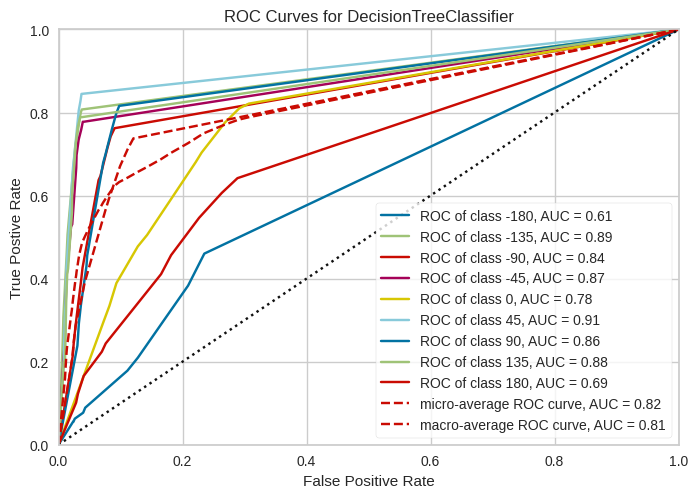

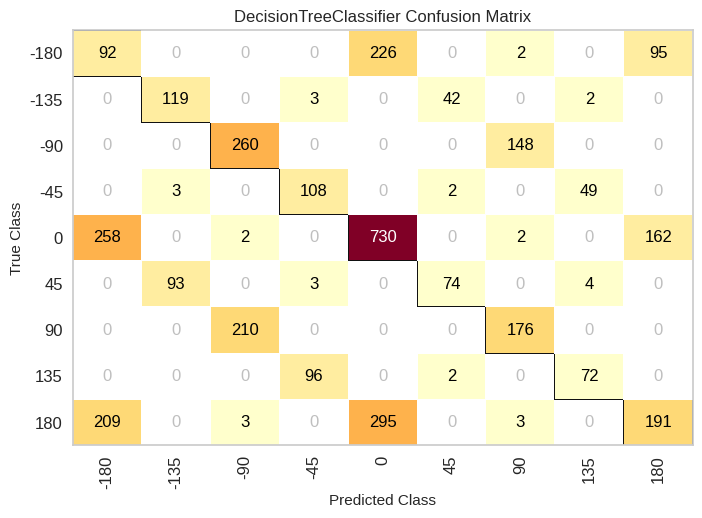

In [24]:
for name, model in models:
    print(name)
    model.fit(X_train, Y_train)
    predictions = model.predict(X_validation)
    print(accuracy_score(Y_validation, predictions))
    print(confusion_matrix(Y_validation, predictions))
    print(classification_report(Y_validation, predictions))

    plt.figure(dpi=100)
    visualizer = ROCAUC(model)
    visualizer.fit(X_train, Y_train)
    visualizer.score(X_validation, Y_validation)
    #visualizer.show(outpath="img/ROC.png", transparent=True, bbox_inches='tight')
    #plt.show()
    g = visualizer.poof()

    plt.figure(dpi=100)
    cm = ConfusionMatrix(model)
    cm.fit(X_train, Y_train)
    cm.score(X_validation, Y_validation)
    #cm.show(outpath="img/c_matrix.png", transparent=True, bbox_inches='tight')
    #plt.show()
    cm.poof()